# Esercizio 4 - Boosting classifier

## Prerequisites

#### Some helper functions from previous exercise

In [1]:
from datetime import timedelta
import os
from datetime import datetime
import itertools
import random
import math


# Takes a timedelta and prints it in a human-readable format.
def format_timedelta(td: timedelta) -> str:
    days = td.days
    years, days = divmod(days, 365)
    months, days = divmod(days, 30)
    hours, remainder = divmod(td.seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    formatted_str = ""
    if years:
        formatted_str += f"{years}y "
    if months:
        formatted_str += f"{months}mo "
    if days:
        formatted_str += f"{days}d "
    if hours:
        formatted_str += f"{hours}h "
    if minutes:
        formatted_str += f"{minutes}m "
    if seconds:
        formatted_str += f"{seconds}s "
    

    
    return formatted_str[:-1] if formatted_str else "0s"
  
# Given a set with binary classes, computes entropy
def compute_entropy(dataset_Y,second_class=-1):
    ones = len(list(filter(lambda classification : classification == 1,dataset_Y)))
    zeros = len(list(filter(lambda classification : classification == second_class,dataset_Y)))

    if(ones == 0 or zeros==0):
        return 0
    
    entropy = ones/len(dataset_Y)*math.log2(1/(ones/len(dataset_Y))) + zeros/len(dataset_Y)*math.log2(1/(zeros/len(dataset_Y)))

    return entropy

# returns a list of tuples (i,x) where i is the index of the patient in the dataset and x is a timedelta of per quanto tempo abbiamo rilevazioni
def find_durations(dataset):
    lengths = []
    for entry in dataset:
        min_t = datetime.max
        max_t = datetime.min
        for item in entry:
            if item[0] < min_t:
                min_t = item[0]
            elif item[0] > max_t:
                max_t = item[0]
        lengths.append(max_t-min_t)
    return [(i, x) for i, x in enumerate(lengths)]

# Find al possible d,l couples that I could split the tree on. Note: Ds are randomly/evenly selected bc otherwise I'd end up with ~36000 pairs...
def create_pairs(dataset_X:list,dataset_ST:list,howmany_d =30,random_sampling=False):

    #1. Create all labels available from current
    labels = set()
    for i in range(0,len(dataset_X)):
        for item in dataset_X[i]:
            if (item[0] > dataset_ST[i]):# Only consider label if it's not been superato
                labels.add(item[1])


    #2. Find all d
    durations = set()
    if random_sampling:
        durations = set()
        for i in range(0,len(dataset_X)):
            for item in dataset_X[i]:
                if (item[0] > dataset_ST[i]): # Only consider timestamp if it's not been superato
                    durations.add(item[0]-dataset_ST[i])
        if len(durations)>howmany_d:
            durations = random.sample(sorted(durations),howmany_d) # Is this ok?
        else:
            durations = sorted(durations)
    else:
        durations = set()
        for i in range(0,len(dataset_X)):
            for item in dataset_X[i]:
                durations.add(item[0]-dataset_ST[i])
        delta = max(durations)/(howmany_d+1)
        durations = set()
        for i in range(1,howmany_d+1):
            durations.add(delta*i)

    return sorted(list(itertools.product(durations,labels)))

# Given a d,l couple, split the dataset and return indexes of true and false entries.
def test_event(dataset_X,dl_pair,dataset_ST):
    i_T = [] # indexes of entries that have label==l within d time
    i_F = [] # indexes of entries that have DON'T HAVE label==l within d time
    d,l = dl_pair


    #1. Separate entries that satisfy event test from those who don't
    for i in range(0,len(dataset_X)):
        entry = dataset_X[i]
        found=False

        for item in entry:
            #print(item)
            if(found is False and item[0]>=dataset_ST[i] and item[0]<=(dataset_ST[i]+d) and item[1]==l ):
                found=True

        if(found):
            i_T.append(i)
        else:
            i_F.append(i)
    return i_T,i_F


#### Loading and parsing DS

In [2]:
def load_diabetes_dataset(verbose=False)-> list: 
    folder_path="datasets\\diabetes"
    dataset = []
    errcount=0
    print(f"-- DS loader")

    for filename in os.listdir(folder_path):

        file_path = os.path.join(folder_path, filename)

        if os.path.isfile(file_path)and filename.startswith('data'):
            entry=[]

            with open(file_path, 'r') as file:
                content = file.readlines()
                for line in content:
                    item = tuple((line[0:-1] if line.endswith('\n') else tuple(line)).split("\t"))

                    # If the item is valid, append it to the entry
                    try:
                        item_f = datetime.strptime(item[0]+" "+item[1], "%m-%d-%Y %H:%M")
                        entry.append((item_f,item[2],item[3]))
                    except:
                        if(verbose):
                            print(f"\t[!] Entry {item} in file {filename} is NOT vallid. Skipped!")
                        errcount+=1
                # add the entry to the dataset
                dataset.append(entry)
    print(f"\tSkipped {errcount} items for formatting issues in data file. {len(dataset)} loaded.")
    return dataset

def compute_datasets(dataset:list,observation_window,waiting_window,prediction_window):

    dataset_X = []
    dataset_Y = []
    
    dataset_ST = [entry[0][0] for entry in dataset ]

    count_excluded=0

    for i in range(0,len(dataset)):
        entry = dataset[i]

        end_obs = dataset_ST[i]+observation_window
        
        start_pred = end_obs + waiting_window
        end_pred = start_pred + prediction_window

        if end_pred < entry[-1][0]:
            entry_X = []
            found = 0

            for item in entry:
                if item[0]>= dataset_ST[i] and item[0]<end_obs:
                    entry_X.append(item)
                if item[0]>=start_pred and item[0]<end_pred:
                    # put Y=1 if it has at least one "65" entry
                    if (item[1]=="65"):
                        found = 1
            dataset_X.append(entry_X)
            dataset_Y.append(found)

        else:
            count_excluded+=1
    
    dataset_ST = [entry[0][0] for entry in dataset_X ]
    dataset_V = [None]*len(dataset_X)
    print(f"-- DS builder")
    print(f"\t{count_excluded} entries unsuitable for selected windows.")
    print(f"\tFinal dataset size: {len(dataset_X)}. Classes: {sum(1 for c in dataset_Y if c == 1)}|{sum(1 for c in dataset_Y if c == 0)}, entropy {float(compute_entropy(dataset_Y,0)):4.3}")    
    return dataset_X,dataset_Y,dataset_ST,dataset_V

# Quick reload if needed for testing/showcasing purposes
def reload_ds():
    # prepare
    dataset = load_diabetes_dataset(False)
    observation_window = timedelta(days=+3)
    waiting_window = timedelta(days=+0)
    prediction_window = timedelta(days=+10)

    dataset_X,dataset_Y, dataset_ST,dataset_V = compute_datasets(dataset,observation_window,waiting_window,prediction_window,)
    return dataset_X[:-1],dataset_Y[:-1], dataset_ST[:-1],dataset_V[:-1]
# Setting up datasets for Boosting task

def reload_boosting():
    dataset_X,dataset_Y, dataset_ST,dataset_V = reload_ds()
    dataset_Y = [(1 if x==1 else -1) for x in dataset_Y] 

    return  dataset_X,dataset_Y, dataset_ST,dataset_V
#print_dataset_state(dataset_X,dataset_Y,dataset_ST,dataset_V,dataset_W)

#### Printing functions

In [3]:
# Prints a table with the number of remaining items, starting time, value if any
def print_dataset_state(dataset_X,dataset_Y,dataset_ST,dataset_V,indexes=None):
    print("--DS state")
    if (indexes and len(indexes)>len(dataset_X)):
        indexes=None

    # Which items do I print?
    if indexes is None:
        indexes = range(0,len(dataset_X))
    
    # Header
    print("index\tX\tY\tST\t\t\tV")
    # Content
    for i in indexes:
        uneaten = [entry for entry in dataset_X[i] if entry[0] >= dataset_ST[i]]
        print(f"{i}\tl.{len(uneaten)}\t{dataset_Y[i]}\t{dataset_ST[i]}\t{dataset_V[i]}\t")

    # Smol final analysis
    print(f"# entries: {len(dataset_X)}, entropy={float(compute_entropy(dataset_Y)):4.3}")

# Prints a table to show weights (and if weights increase or decrease) for each item and for each iteration, + err/alpha
def print_weights_status(training_W,dataset_Y,training_alpha, training_err,range_to_print=None):
    
    # Which items do I print?
    if range_to_print is None:
        range_to_print=range(0,len(dataset_Y))


    # Header
    print("i\t",end="")
    for i in range(0,len(training_W)):
        print(f"w{i}\t\t",end="")
    print("")


    # Content
    for item in range_to_print: #each row in the DS
        print(f"{item}\t",end="")
        for step in range(0,len(training_W)): # each weight
            print(f"{training_W[step][item]:4.2}",end="")
            if step!=0:
                andamento = f"{"\x1b[31m↑\033[0;37m" if training_W[step-1][item]<training_W[step][item] else "\033[0;32m↓\033[0;37m"}"
                if training_W[step-1][item]==training_W[step][item]:
                    andamento="!"
                print(andamento,end="")
            print("\t\t",end="")
        print("")

    # Final row to display alpha and error
    print("α\t",end="")
    for i in range(0,len(training_alpha)):
        print(f"{training_alpha[i]:4.2}\t\t",end="")
    print("(done)")    
    print("err\t",end="")
    for i in range(0,len(training_err)):
        print(f"{training_err[i]:4.2}\t\t",end="")
    print("(done)")

    return


#### Weighted entropy and IG (from professor!!)

In [4]:
# information gain for weighted samples
# (weight, label)
l = [[(2.3, 1),(4.3, 1), (8.3, 1), (3, -1),( 0.9, 1 ), (99, -1) ],[(99, 1),(8.3, 1), (1.3, -1), (2.3, -1), (9,1)]]
import pandas as pd
from math import log2

# Takes a tuple (weights, true labels) and returns a tuple (entropy, weight)
def weighted_entropy(lp):
    df = pd.DataFrame([{"w":x[0], "l":x[1]} for x in lp])
    try:
        return (df.groupby("l").sum() / df["w"].sum())["w"].apply(lambda x: -x * log2(x)).sum(), df["w"].sum()
    except:
        print(lp)

# Takes a tuple (  (weights,true_labels)  ,  (weights, true_labels)  ) and returns the ig
def weighted_ig(split,verbose=False):
    e, w = weighted_entropy(split[0] + split[1])
    e0, w0  = weighted_entropy(split[0])
    e1, w1  = weighted_entropy(split[1])
    if verbose:
        print(f"before split: e{e:4.2}, w{w:4.2}")
        print(f"after split: e0 {e0 :4.2} w0 {w0 :4.2} / e1 {e1 :4.2} w1 {w1 :4.2}")
    return e - (w0 / w) * e0 - (w1 / w) * e1

In [5]:
# Helper function that returns classification 
def compute_weighted_majority(dataset_Y,weights,indexes,verbose=False):
    # Sum weight*prediction
    classification=0
    for i in indexes:
        classification += dataset_Y[i]*weights[i]
    
    if verbose:
        print("votes for final classification:",classification/weights[i])

    else:
        classification = -1 if classification < 0 else 1
    return classification

## Sequence trunk definition
Most of functionality is kept from previous exercise; notable changes are in the "fit" function, as tree shape is now predefined and doesn't need recursive construction anymore.

In [6]:
from treelib import Tree,Node

class SequenceTrunk(Tree):

    #  -- FUNDAMENTALS

    def __init__(self, tree=None, deep=False, node_class=None, identifier=None):
        super(SequenceTrunk, self).__init__(tree=tree, deep=deep, node_class=node_class, identifier=identifier)

    # Library has a bug that won't show trees correctly unless stdout=False is added.
    def display(self):
        print(self.show(stdout=False))

    #  -- NEW NODE GENERATION

    # Let's override original create_node method in order to add new constraints such as child node number and true/false branchs.
    # In order to create nodes, however, we'll always use create_node_* functions
    def create_node(self, tag=None, identifier=None, parent=None, data=None,branch=None):
        """
        Create a child node for the given @parent node. If ``identifier`` is absent,
        a UUID will be generated automatically.
        """
        
        new_node = super(SequenceTrunk, self).create_node(tag=tag, parent=parent, data=data)
        siblings = super(SequenceTrunk,self).siblings(new_node.identifier)
        
        if len(super(SequenceTrunk,self).siblings(new_node.identifier))>=2:
           raise ValueError("Parent node already has maximum number of children")

        if branch in [x.data["branch"] for x in siblings]:
           raise ValueError(f"Parent node already has a {branch} branch")
        
        return new_node
    
    def create_node_event(self,data,parent=None,branch=None,entropy="",size=0,ig="",index="",weight=0.0):
        branch_f = "" if (branch is None) else str(branch)+" "
        tag =  f"\x1b[32m⬤ {branch_f} ({str(data[1])},{format_timedelta(data[0])})\x1b[0m - [e={float(entropy):4.2} ig={float(ig):4.2} w={float(weight):4.2}] [n={size}] {index}"
        data = {"branch":branch, "dl":(data[0],data[1]),"entropy":entropy,"ig":ig,"index":index,"weights":weight}

        return     self.create_node(tag,data=data,parent=parent,branch=branch)

    def create_node_value(self,label_value,parent=None,branch=None,entropy="",size=0,ig="",index="",weight=0.0):
        branch_f = "" if (branch is None) else branch+" "
        tag =  f"\x1b[31m■ {branch_f} ({label_value}) \x1b[0m- [e={float(entropy):2.2} ig={ig:4.2} w={float(weight):4.2}] [n={size}] {index}"
        data = {"branch":branch,"value":label_value,"entropy":entropy,"index":index,"weights":weight}
        return     self.create_node(tag,data=data,parent=parent,branch=branch)

    def create_node_class(self,classification,parent=None,branch=None,entropy="",size=0,index="",weight=0.0):
        branch_f = "" if (branch is None) else str(branch)+" "

        tag =  f"\x1b[33m◆ {branch_f} {classification} \x1b[0m- [e={float(entropy):2.2} w={float(weight):4.2}] \x1b[33m[n={size}]\x1b[0m - {index}"

        # If the classsification had "max length reached", remove the tag from data
        if isinstance(classification, str):
            classification = int(classification[0])

        data = {"branch":branch, "class":classification,"entropy":entropy,"index":index,"weights":weight}


        return     self.create_node(tag,data=data,parent=parent,branch=branch)

    #  -- EVENT TESTING

    # Given a d,l couple, split the dataset in two + update starting times and dataset values.
    # Return indexes and updated datasets.
    def perform_event_test(self,max_dl,indexes,dataset_X,ds_ST,dataset_V,verbose=False):
        # divide dataset in t and f...
        i_T = []
        i_F = []

        d,l = max_dl
        old_dataset_ST=ds_ST.copy()
        new_dataset_ST=ds_ST.copy()
        new_dataset_V=dataset_V.copy()
        
        for i in range(0,len(ds_ST)):
            entry = dataset_X[i]
            found=False

            for item in entry:
                # Couple of checks to avoid errors,,
                if isinstance(old_dataset_ST[i],list):
                    old_dataset_ST[i] = old_dataset_ST[i][0]
                if isinstance(item[0],tuple):
                    item[0] = item[0][0]
                    
                # Starting from the starting time, see if it exists an item with timestamp < d and label == l
                if(found is False and item[0]>= old_dataset_ST[i] and item[0]<=(old_dataset_ST[i]+d) and item[1]==l ): # If i'm over starting time
                    found=True
                    new_dataset_ST[i] = item[0]
                    new_dataset_V[i] = item[2]
                    
            if(found):
                i_T.append(i)
            else:
                i_F.append(i)
                
        return i_T,i_F,new_dataset_ST,new_dataset_V

    #  -- VALUE TESTING

    # Given a d,l couple, split the dataset in two 
    def __perform_value_test(self,value,dataset_V,indexes=None):
        i_T=[]
        i_F=[]

        if indexes == None:
            indexes = range(0,len(dataset_V))

        for i in indexes:
            if dataset_V[i] <= value:
                i_T.append(i)
            else:
                i_F.append(i)
        return i_T,i_F

    #  -- FIT ALGORITHM
        
    def fit(self,d,l,v,dataset_X,dataset_Y,dataset_V,dataset_ST,weights,verbose=False):
    # Tree shape is now predefined, so fit algorithm doesn't need to be recursive anymore and it just build the same structure node per node.
        self.d = d
        self.l = l
        self.v = v

        # -- ROOT NODE
        i_T,i_F = test_event(dataset_X,(d,l),dataset_ST)


        # If test didn't divide dataset, this thruple is unusable and no tree is generated.
        if len(i_T) == 0 or len(i_F)== 0:
            return None

        # Otherwise, split dataset and generate root node (event test)
        l_T = [(weights[i],dataset_Y[i]) for i in i_T] # couples of weights and true label
        l_F = [(weights[i],dataset_Y[i]) for i in i_F]
        ig = weighted_ig([l_T,l_F])
        
        
        parent = self.create_node_event((d,l),None,None,weighted_entropy(l_T+l_F)[0],len(i_T)+len(i_F),ig,"",weighted_entropy(l_T+l_F)[1])

        # -- FALSE TEST LEAF
        
        # Find majority class (using weights!) and create root->false->class node.
        classification = compute_weighted_majority(dataset_Y,weights,i_F,verbose)
        self.create_node_class(classification,parent, "f",weighted_entropy(l_F)[0],len(i_F),i_F,weighted_entropy(l_F)[1])
        
        
        # -- TRUE TEST NODE: VALUE TEST
        
        # Take only items that are true on the event test for following nodes.
        new_dataset_V = dataset_V.copy() # python was bugging out a lot, tried this and other fixes, now it works and I'm leaaving this just to be safe
        new_dataset_ST = dataset_ST.copy()
        _,_,new_dataset_ST,new_dataset_V = self.perform_event_test((d,l),i_T,dataset_X,new_dataset_ST,new_dataset_V)
       
        # Now separate true event test items based on value test. 
        ivalue_T, ivalue_F = self.__perform_value_test(v,new_dataset_V,i_T)

        # If no split can be found, no tree with predefined structure can be built. Return no tree.
        if len(ivalue_T) == 0 or len(ivalue_F) == 0:
            return None
        
        # Else, split the dataset again! 
        lvalue_T = [(weights[i],dataset_Y[i]) for i in ivalue_T]
        lvalue_F = [(weights[i],dataset_Y[i]) for i in ivalue_F]

        ig_value = weighted_ig([lvalue_T,lvalue_F])
        value_node = self.create_node_value(v,parent,"t",weighted_entropy(l_T)[0],len(l_T),ig_value,i_T,weighted_entropy(l_T)[1])

        # ---- VALUE LEAVES
        classification_value_true = compute_weighted_majority(dataset_Y,weights,ivalue_T,verbose)
        classification_value_false = compute_weighted_majority(dataset_Y,weights,ivalue_F,verbose)

        self.create_node_class(classification_value_true,value_node, "t",weighted_entropy(lvalue_T)[0],len(lvalue_T),ivalue_T,weighted_entropy(lvalue_T)[1])
        self.create_node_class(classification_value_false,value_node, "f",weighted_entropy(lvalue_F)[0],len(lvalue_F),ivalue_F,weighted_entropy(lvalue_F)[1])

        
        return (new_dataset_ST,new_dataset_V)
    
    #  -- PREDICT ALGORITHM

    def __predict_r(self,entry_X,entry_ST,entry_V,node:Node,verbose=False):

        if verbose:
            print(node)
            
        # BASE CASE
        
        if node.is_leaf():
            if verbose:
                print("end")
            return node.data["class"]


        # INDUCTIVE CASE    

        children = [self.get_node(x) for x in node.successors(self.identifier)]

        if "dl" in node.data.keys():
            if verbose:
                print("dl test")
            i_T,i_F,entry_ST,entry_V = self.perform_event_test(node.data["dl"],None,entry_X,entry_ST,entry_V)

            branch = "t" if i_T else "f"
            next_node = list(filter(lambda x : x.data["branch"]==branch,children))
            next_node = next_node[0]

            return self.__predict_r(entry_X,entry_ST,entry_V,next_node)

        elif "value" in node.data.keys():
            if verbose:
                print("value test")
            try:
                i_T,i_F = self.__perform_value_test(node.data["value"],entry_V)
            except:
                print(node.data)
            branch = "t" if i_T else "f"
            next_node = list(filter(lambda x : x.data["branch"]==branch,children))[0]

            return self.__predict_r(entry_X,entry_ST,entry_V,next_node)

    # Given a list of new entries, computes the prediction and returns it. It also prints the confusion matrix!
    def predict(self,entry_X,entry_ST,entry_V,entry_Y=None,verbose=False):
        if verbose:
            print("-- Predict")
        results=[]
        root = self.get_node(self.root)


        if len(entry_V)==1:
            entry_X = [entry_X]
            if entry_Y is not None:
                entry_Y = [entry_Y]
            entry_ST = [entry_ST]
            entry_V = [entry_V]
            results.append(self.__predict_r(entry_X,entry_ST,entry_V,root,verbose))
        else:
            for i in range(0,len(entry_ST)):
                results.append(self.__predict_r([entry_X[i]],[entry_ST[i]],[entry_V[i]],root,verbose))
        
        if entry_Y is not None:
            if verbose:
                tp = sum(1 for x, y in zip(results, entry_Y) if (x == 1 and y==1))
                tn = sum(1 for x, y in zip(results, entry_Y) if (x == 0 and y==0))
                fp = sum(1 for x, y in zip(results, entry_Y) if (x == 1 and y==0))
                fn = sum(1 for x, y in zip(results, entry_Y) if (x == 0 and y==1))

                print(f"\tP\tN\nP\t{tp}\t{fn}\nN\t{fp}\t{tn}")
                print(f"Items: {tp+tn+fp+fn}")
                print(f"Accuracy: {float((tp+tn)/(tp+tn+fp+fn)):4.3}")

        return results

## Training script (Boosting)


In [7]:
import matplotlib.pyplot as plt

class BoostingClassifier:
    # Given a dataset, trains a tree boosting classifier as defined in class.
    def train(self,iTERATIONS, how_many_candidates, dataset):
        random.seed()
        self.iTERATIONS = iTERATIONS # save number of iterations used for training, in order to easily print data later

        # Load dataset
        dataset_X,dataset_Y, dataset_ST,dataset_V = dataset

        # -- INITIALIZATION
        # initialize training data
        weights = [1/(len(dataset_Y))]*len(dataset_Y)
        training_ST = [dataset_ST]
        training_V = [dataset_V]
        training_alphas = []
        training_errors = []
        training_phis= []
        training_W = [weights]


        # -- TRAINING ALGORITHM

        for iteration in range(0,iTERATIONS):

            # - FIND BEST TREE

            # -- 1. Find all possible thruples of l,d,v
            candidates = set()
            count=0
            for entry_i in range(0,len(dataset_X)):
                for item in dataset_X[entry_i]:
                    if item[0] > training_ST[iteration][entry_i]:
                        candidates.add((item[0]-dataset_ST[entry_i],item[1],item[2]))
                        count+=1          
            candidates = list(random.sample(list(candidates),how_many_candidates)) # I sample candidates because my computer has weak p energy


            # -- 2. For each candidate throuple, create sequence trunk and save error
            candidate_trees = []
            # for each thruple, compute tree
            for candidate in candidates:
                st = SequenceTrunk()
                result = st.fit(candidate[0],candidate[1],candidate[2],dataset_X,dataset_Y,(training_V[iteration]).copy(),(training_ST[iteration]).copy(),training_W[iteration])
                if result is not None:
                    # Tree was found: compute WEIGHTED tree error
                    err=0
                    for leaf in st.leaves():
                        for i in leaf.data["index"]:
                            if not dataset_Y[i] == leaf.data["class"]: # if prediction was wrong add weighted error :)
                                err+=weights[i]
                    candidate_trees.append((st,err,candidate,result[0],result[1])) 
                else:
                    # Tree was not found: try again with next thruple
                    continue
            # If it couldn't find even a single tree, quit where you are and save how many iterations you could do before quitting 
            if len(candidate_trees)==0:
                print("COULDNT FIND ANY VIABLE TREES IN ITERATION. QUITTING.")
                iTERATIONS=iteration
                break


            # -- 3. Find best tree for this iteration
            min_tuple = min(candidate_trees, key=lambda x: x[1])
            err = min_tuple[1]
            best_test = min_tuple[2]
            best_tree = min_tuple[0]


            # - COMPUTE NEW WEIGHTS AND TRAINING VALUES

            # -- 1. Alpha
            alpha = 0.5 * math.log2((1-err)/err)

            # -- 2. Weights
            # --- find correct/mistaken items
            i_correct = []
            i_mistaken = []
            for i_entry in range(0,len(dataset_Y)):
                for leaf in min_tuple[0].leaves():
                    if i_entry in leaf.data["index"]:
                        if dataset_Y[i_entry] == leaf.data["class"]:
                            i_correct.append(i_entry)
                            continue
                        else:
                            i_mistaken.append(i_entry)
                            
            weights_new = [None]*len(dataset_Y)
            # --- Assign new weights according to formula
            for i in i_mistaken:  
                weights_new[i]   =  training_W[iteration][i] * math.sqrt((1-err)/err)
            for i in i_correct:
                weights_new[i]   =  training_W[iteration][i] * math.sqrt((err)/(1-err))
            z = sum(weights_new)
            weights_new = [w/z for w in weights_new]

            # If Weights stayed the same, something is wrong (weight deltas so wrong that we got over the machine limit... or just bugs in my algorithm)
            for i in range(0,len(dataset_Y)):
                if weights_new[i] == weights[i]:
                    print("!!!")
                    break

            # - FINALLY: update verything for next step
            training_ST.append(min_tuple[3])
            training_V.append(min_tuple[4])
            training_W.append(weights_new.copy())
            training_errors.append(err)
            training_alphas.append(alpha)
            training_phis.append(best_tree)

            print(f"Iteration {iteration+1}/{iTERATIONS} done!")


        # Tranining is all done: save it all inside the object for further use
        self.training_W = training_W
        self.training_ST = training_ST
        self.training_V = training_V
        self.training_alphas = training_alphas
        self.training_errors = training_errors
        self.training_phis= training_phis
        self.training_W = training_W
        self.dataset_Y = dataset_Y
        self.dataset_X = dataset_X

    # Prints a table with weights for all items, and their trend over iterations
    def print_weights_status(self):
        if not hasattr(self,"iTERATIONS"):
            print("Classifier has not been trained yet!")
            return
        print_weights_status(self.training_W,self.dataset_Y,self.training_alphas,self.training_errors)

    # Uses a trained sequence trunk booster classifier to predict class for an item or a list of items.
    def predict(self,test_X,test_V,test_ST,test_Y,verbose=False):

        # The classifier must have been trained
        if not hasattr(self,"iTERATIONS"):
            print("Classifier has not been trained yet!")
            return 
    
        # -- 1. First, let's just reuse the tree predict function and let's get simple prediction for all requested items in each iteration.
        raw_predictions=[]

        # For each tree in classifier, compute predictions and update datasets ST and V
        for tree_i in range(0,len(self.training_phis)):
            raw_predictions.append(self.training_phis[tree_i].predict(test_X,test_ST,test_V)) #update ST and V each
            _,_,test_ST,test_V = self.training_phis[tree_i].perform_event_test((self.training_phis[tree_i].d,self.training_phis[tree_i].l),None,test_X,test_ST,test_V)

        # -- 2. Now sum all predictions and apply alphas
        weighted_predictions = [0]*len(test_V)
        for iteration in range(0,self.iTERATIONS):
            for item_i in range(0,len(test_V)):
                weighted_predictions[item_i] += self.training_alphas[iteration] * raw_predictions[iteration][item_i]

        # -- 3. Cap to 1/-1
        weighted_predictions = [-1 if p < 0 else 1 for p in weighted_predictions]

        # Some stats, if you want them
        if test_Y is not None:
            if verbose:
                tp = sum(1 for x, y in zip(weighted_predictions, test_Y) if (x == 1 and y==1))
                tn = sum(1 for x, y in zip(weighted_predictions, test_Y) if (x == -1 and y==-1))
                fp = sum(1 for x, y in zip(weighted_predictions, test_Y) if (x == 1 and y==-1))
                fn = sum(1 for x, y in zip(weighted_predictions, test_Y) if (x == -1 and y==1))

                print(f"\tP\tN\nP\t{tp}\t{fn}\nN\t{fp}\t{tn}")
                print(f"Items: {tp+tn+fp+fn}")
                print(f"Accuracy: {float((tp+tn)/(tp+tn+fp+fn)):4.3}")

        # All done!
        return weighted_predictions
                
    # Computes error variation for each iteration (aka, it inferences using trees [0] and saves error, [0,1] and saves error, ...)
    def compute_training_errors(self):

        # If tree has not been trained, quit
        if not hasattr(self,"iTERATIONS"):
            print("Classifier has not been trained yet!")
            return
        
        # - COMPUTATION

        errs=[]
        predictions=[]
        # for each tree in classifier, compute predictions
        for tree_i in range(0,len(self.training_phis)):
            predictions.append(self.training_phis[tree_i].predict(self.dataset_X,self.training_ST[tree_i],self.training_V[tree_i],self.dataset_Y))


        # Now, for each iteration compute error to be saved in array
        for iteration in range(0,self.iTERATIONS):
            count_err = 0
            # compute prediction for each item
            for item_i in range(0,len(self.dataset_Y)):
                # in order to know prediction, compute prediction by sum of prediction of each tree (up to current iteration) * alpha of that iteration
                pred=0
                for i in range(0,iteration):
                    pred += self.training_alphas[i]*predictions[i][item_i]
                pred = -1 if pred < 0 else 1
                # If prediction was wrong, add error :(
                if pred != self.dataset_Y[item_i]:
                    count_err+=1
            # convert error to percentage
            err = count_err/len(self.dataset_Y)
            # save error
            errs.append(err)
        # save prediction errors into object just in case
        self.prediction_errors = errs
        return errs
    
    # Prints a plot that showcases the trend of error with each iteration.
    def print_error_trend(self):
        plt.figure(figsize=(6,3))  # Width, Height in inches
        # Adding labels
        plt.xlabel('iterations')
        plt.ylabel('alpha/err')
        plt.plot(self.training_errors,label="error",color="orange")
        plt.plot(self.training_alphas,label="alpha",color="green")
        self.compute_training_errors()
        plt.plot(self.prediction_errors,label="prediction error",color="#cc0000",linewidth=3)
        _ = plt.legend(loc='upper right')
        plt.grid(color='grey', linestyle='--', linewidth=.5)
        # Displaying the plot
        plt.show()

    # Prints two plots, attempting to show in a human-readable way how all weights vary across iterations.
    def print_weights_stats(self):
        
        # 1. Compute range of weights for each iteration

        max_weights = []
        min_weights = []

        for i in range(0,self.iTERATIONS):
            max_weights.append(max(self.training_W[i]))
            min_weights.append(min(self.training_W[i]))

        import matplotlib.pyplot as plt


        # 2. Show raw weight trend for all iterations and weights (quite messy!)
        plt.figure(figsize=(15,5))
        plt.plot(self.training_W)
        plt.xlabel('Iteration')
        plt.ylabel('Weights value')
        plt.title('Weight evolution over iteration')
        plt.grid(color='grey', linestyle='--', linewidth=.5)
        plt.show()
        

        # 3. Show boxplot for each iteration + min/max 
        plt.figure(figsize=(15,5))  # Width, Height in inches
        # Adding labels
        plt.xlabel('Iteration')
        plt.ylabel('max/min weight')
        plt.title('Box plot of weights per iteration')
        plt.plot(min_weights,label="min",color="green",linestyle="--")
        plt.plot(max_weights,label="max",color="orange",linestyle="--")
        
        _ = plt.legend(loc='upper right')
        plt.grid(color='grey', linestyle='--', linewidth=.5)


        plt.boxplot(self.training_W,labels=list(range(0,len(self.training_W))),positions=range(0,len(self.training_W)),vert=True,sym='.', boxprops=dict(color="grey"), whiskerprops=dict(color="grey"))
        # Displaying the plot
        plt.show()

## Run everything!

In [8]:
boosting_classifier = BoostingClassifier()

# Train dataset
dataset_X,dataset_Y, dataset_ST,dataset_V = reload_boosting()
boosting_classifier.train(50,20,(dataset_X[:50],dataset_Y[:50], dataset_ST[:50],dataset_V[:50]))
boosting_classifier.print_weights_status()

-- DS loader
	Skipped 46 items for formatting issues in data file. 70 loaded.
-- DS builder
	2 entries unsuitable for selected windows.
	Final dataset size: 68. Classes: 31|37, entropy 0.994
Iteration 1/50 done!
Iteration 2/50 done!
Iteration 3/50 done!
Iteration 4/50 done!
Iteration 5/50 done!
Iteration 6/50 done!
Iteration 7/50 done!
Iteration 8/50 done!
Iteration 9/50 done!
Iteration 10/50 done!
Iteration 11/50 done!
Iteration 12/50 done!
Iteration 13/50 done!
Iteration 14/50 done!
Iteration 15/50 done!
Iteration 16/50 done!
Iteration 17/50 done!
Iteration 18/50 done!
Iteration 19/50 done!
Iteration 20/50 done!
Iteration 21/50 done!
Iteration 22/50 done!
Iteration 23/50 done!
Iteration 24/50 done!
Iteration 25/50 done!
Iteration 26/50 done!
Iteration 27/50 done!
Iteration 28/50 done!
Iteration 29/50 done!
Iteration 30/50 done!
Iteration 31/50 done!
Iteration 32/50 done!
Iteration 33/50 done!
Iteration 34/50 done!
Iteration 35/50 done!
Iteration 36/50 done!
Iteration 37/50 done!
Iter

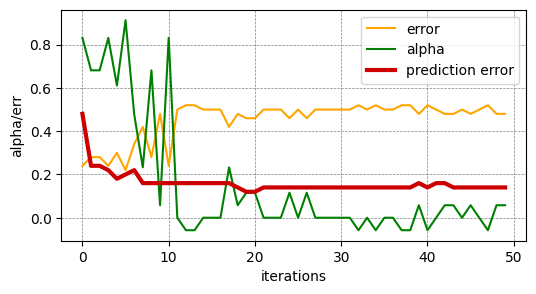

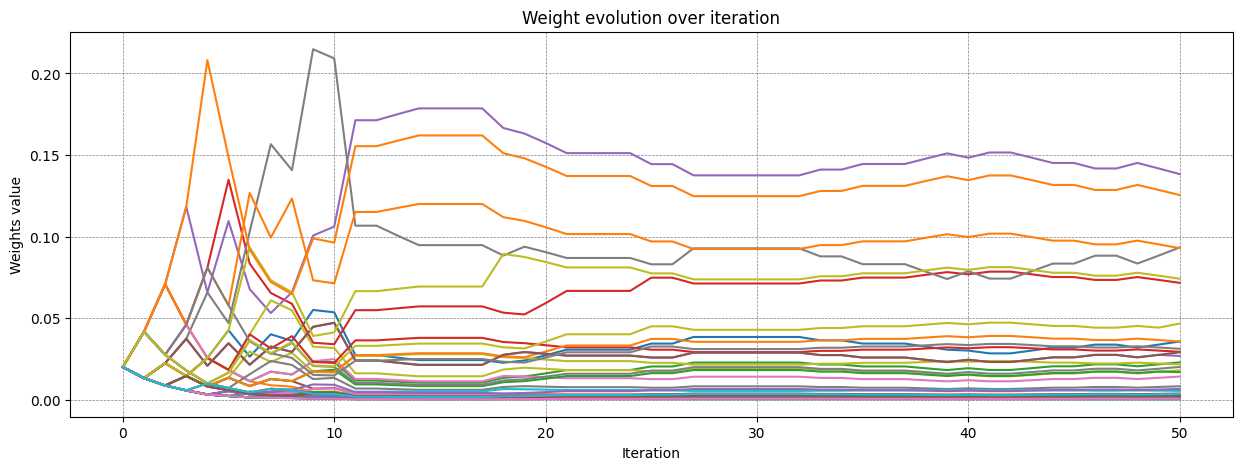

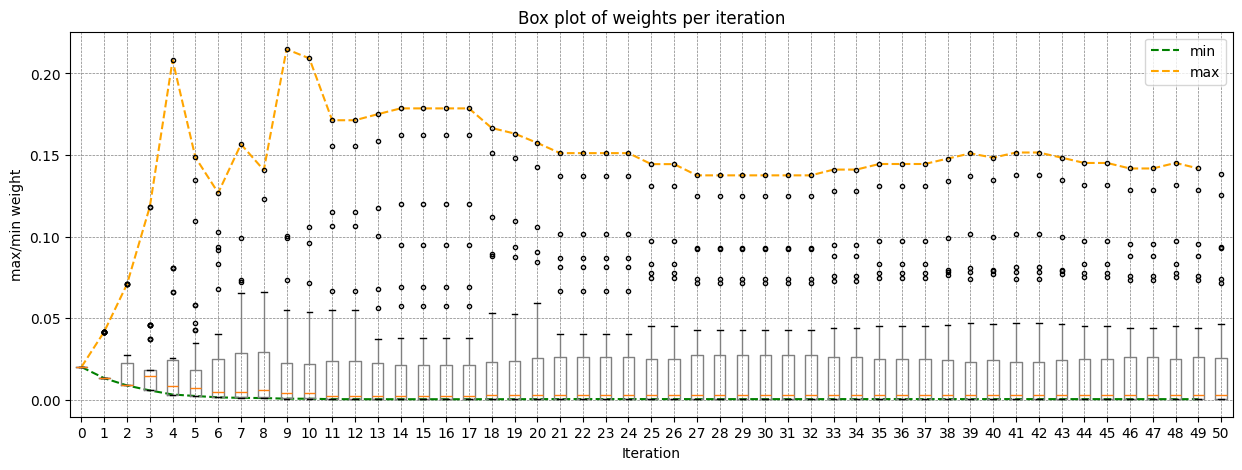

In [9]:
boosting_classifier.print_error_trend()
boosting_classifier.print_weights_stats()

In [10]:
# Predict class for new items
_ = boosting_classifier.predict(dataset_X[50:],dataset_V[50:],dataset_ST[50:],dataset_Y[50:],True)

	P	N
P	4	1
N	6	6
Items: 17
Accuracy: 0.588
